In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vedujod99/AAPL_1h.csv
/kaggle/input/vedujod99/AAPL_15m.csv
/kaggle/input/vedujod99/AAPL_1d.csv


/tmp/ipykernel_30/3231468914.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['50_MA'][i] > data['200_MA'][i] and position == 0:
/tmp/ipykernel_30/3231468914.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  position = position_size / data['close'][i]
/tmp/ipykernel_30/3231468914.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trade_log.append({'Date': data.index[i], 'Action': 'Buy', 'Price': data['close'][i], 'S

Trend-Following Strategy Final Balance: 103829.84932243922
Mean-Reversion Strategy Final Balance: 101018.91715832292
Momentum Strategy Final Balance: 103223.53119231973


<Figure size 1000x600 with 0 Axes>

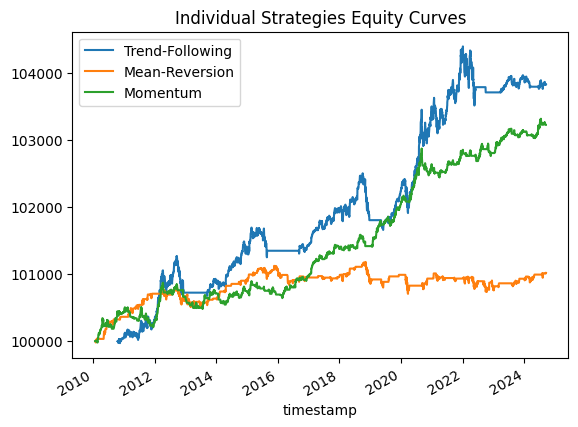

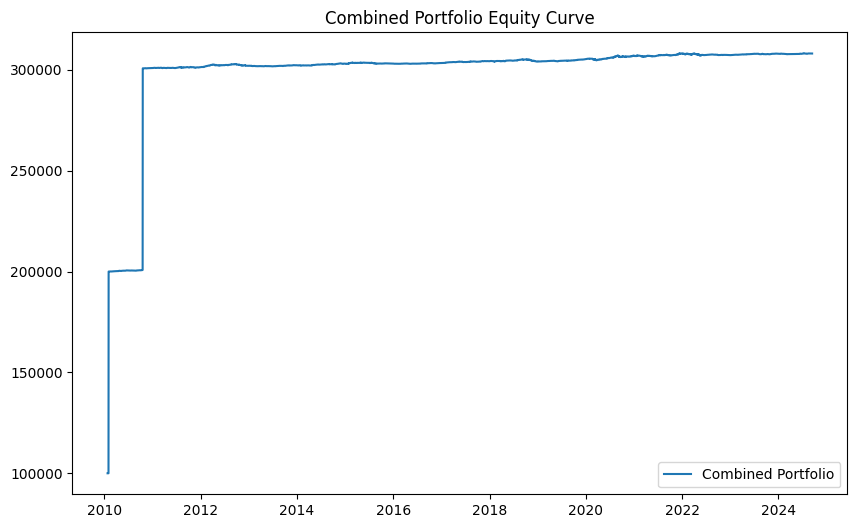

Correlation Matrix:
                 Trend-Following  Mean-Reversion  Momentum
Trend-Following         1.000000        0.539932  0.969581
Mean-Reversion          0.539932        1.000000  0.490747
Momentum                0.969581        0.490747  1.000000

Trend-Following Trade Log:
                  Date Action     Price     Shares
0  2010-10-19 04:00:00    Buy   11.0532  90.471538
1  2012-12-07 05:00:00   Sell   19.0446  90.471538
2  2013-09-12 04:00:00    Buy   16.8818  59.235390
3  2015-08-26 04:00:00   Sell   27.4225  59.235390
4  2016-09-02 04:00:00    Buy   26.9325  37.129862
5  2018-12-20 05:00:00   Sell   39.2075  37.129862
6  2019-05-07 04:00:00    Buy   50.7150  19.718032
7  2022-06-02 04:00:00   Sell  151.2100  19.718032
8  2022-09-28 04:00:00    Buy  149.8400   6.673785
9  2022-09-30 04:00:00   Sell  138.2000   6.673785
10 2023-03-22 04:00:00    Buy  157.8300   6.335931
11 2024-03-13 04:00:00   Sell  171.1300   6.335931
12 2024-06-13 04:00:00    Buy  214.2400   4.667662

M

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
# Replace 'your_data.csv' with your actual data file path
data = pd.read_csv('/kaggle/input/vedujod99/AAPL_1d.csv', parse_dates=['timestamp'], index_col='timestamp')

# Define the Trend-Following Strategy
def trend_following_strategy(data, short_window=50, long_window=200, position_size=1000):
    data['50_MA'] = data['close'].rolling(window=short_window).mean()
    data['200_MA'] = data['close'].rolling(window=long_window).mean()
    
    balance = 100000
    position = 0
    trade_log = []
    equity_curve = []

    for i in range(long_window, len(data)):
        # Buy signal: Short-term MA crosses above long-term MA
        if data['50_MA'][i] > data['200_MA'][i] and position == 0:
            position = position_size / data['close'][i]
            balance -= position_size
            trade_log.append({'Date': data.index[i], 'Action': 'Buy', 'Price': data['close'][i], 'Shares': position})
        
        # Sell signal: Short-term MA crosses below long-term MA
        elif data['50_MA'][i] < data['200_MA'][i] and position > 0:
            balance += position * data['close'][i]
            trade_log.append({'Date': data.index[i], 'Action': 'Sell', 'Price': data['close'][i], 'Shares': position})
            position = 0
        
        equity_curve.append(balance + position * data['close'][i])
    
    final_balance = balance + position * data['close'].iloc[-1]
    return pd.DataFrame(trade_log), final_balance, pd.Series(equity_curve, index=data.index[long_window:])

# Define the Mean-Reversion Strategy
def mean_reversion_strategy(data, window=20, z_entry=-1.0, z_exit=0.5, position_size=1000):
    data['mean'] = data['close'].rolling(window=window).mean()
    data['std'] = data['close'].rolling(window=window).std()
    data['z_score'] = (data['close'] - data['mean']) / data['std']
    
    balance = 100000
    position = 0
    trade_log = []
    equity_curve = []

    for i in range(window, len(data)):
        # Entry signal: Buy if z_score < z_entry (negative threshold)
        if data['z_score'][i] < z_entry and position == 0:
            position = position_size / data['close'][i]
            balance -= position_size
            trade_log.append({'Date': data.index[i], 'Action': 'Buy', 'Price': data['close'][i], 'Shares': position})
        
        # Exit signal: Sell if z_score > z_exit
        elif data['z_score'][i] > z_exit and position > 0:
            balance += position * data['close'][i]
            trade_log.append({'Date': data.index[i], 'Action': 'Sell', 'Price': data['close'][i], 'Shares': position})
            position = 0

        equity_curve.append(balance + position * data['close'][i])
    
    final_balance = balance + position * data['close'].iloc[-1]
    return pd.DataFrame(trade_log), final_balance, pd.Series(equity_curve, index=data.index[window:])

# Define the Momentum Strategy
def momentum_strategy(data, window=14, threshold=0.02, position_size=1000):
    data['momentum'] = data['close'].diff(window)
    
    balance = 100000
    position = 0
    trade_log = []
    equity_curve = []

    for i in range(window, len(data)):
        # Entry signal: Buy if momentum > threshold and position == 0
        if data['momentum'][i] > threshold and position == 0:
            position = position_size / data['close'][i]
            balance -= position_size
            trade_log.append({'Date': data.index[i], 'Action': 'Buy', 'Price': data['close'][i], 'Shares': position})
        
        # Exit signal: Sell if momentum < -threshold and position > 0
        elif data['momentum'][i] < -threshold and position > 0:
            balance += position * data['close'][i]
            trade_log.append({'Date': data.index[i], 'Action': 'Sell', 'Price': data['close'][i], 'Shares': position})
            position = 0

        equity_curve.append(balance + position * data['close'][i])
    
    final_balance = balance + position * data['close'].iloc[-1]
    return pd.DataFrame(trade_log), final_balance, pd.Series(equity_curve, index=data.index[window:])

# Backtest all three strategies
trend_following_trade_log, trend_following_final_balance, trend_following_equity_curve = trend_following_strategy(data)
mean_reversion_trade_log, mean_reversion_final_balance, mean_reversion_equity_curve = mean_reversion_strategy(data)
momentum_trade_log, momentum_final_balance, momentum_equity_curve = momentum_strategy(data)

# Print results
print("Trend-Following Strategy Final Balance:", trend_following_final_balance)
print("Mean-Reversion Strategy Final Balance:", mean_reversion_final_balance)
print("Momentum Strategy Final Balance:", momentum_final_balance)

# Example code to remove duplicates
trend_following_equity_curve = trend_following_equity_curve[~trend_following_equity_curve.index.duplicated(keep='last')]
mean_reversion_equity_curve = mean_reversion_equity_curve[~mean_reversion_equity_curve.index.duplicated(keep='last')]
momentum_equity_curve = momentum_equity_curve[~momentum_equity_curve.index.duplicated(keep='last')]


# Combine trade logs and equity curves for portfolio analysis
strategies_results = {
    'Trend-Following': trend_following_trade_log,
    'Mean-Reversion': mean_reversion_trade_log,
    'Momentum': momentum_trade_log
}

# Combine equity curves of all strategies into one DataFrame
equity_curves = pd.DataFrame({
    'Trend-Following': trend_following_equity_curve,
    'Mean-Reversion': mean_reversion_equity_curve,
    'Momentum': momentum_equity_curve
})

# Calculate portfolio returns
portfolio_returns = equity_curves.sum(axis=1)

# Plot the individual equity curves and combined portfolio equity curve
plt.figure(figsize=(10, 6))
equity_curves.plot(title='Individual Strategies Equity Curves')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(portfolio_returns, label='Combined Portfolio')
plt.title('Combined Portfolio Equity Curve')
plt.legend()
plt.show()

# Calculate correlation matrix
correlation_matrix = equity_curves.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Summarize Trade Logs
for strategy, log in strategies_results.items():
    print(f"\n{strategy} Trade Log:")
    print(log)


/tmp/ipykernel_30/545223034.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (equity_curve[-1] / equity_curve[0]) ** (1 / n_years) - 1


Performance Metrics for Trend-Following:
CAGR: 0.27%
Sharpe Ratio: 0.63
Max Drawdown: -0.84%

Performance Metrics for Mean-Reversion:
CAGR: 0.07%
Sharpe Ratio: 0.37
Max Drawdown: -0.47%

Performance Metrics for Momentum:
CAGR: 0.22%
Sharpe Ratio: 1.08
Max Drawdown: -0.42%



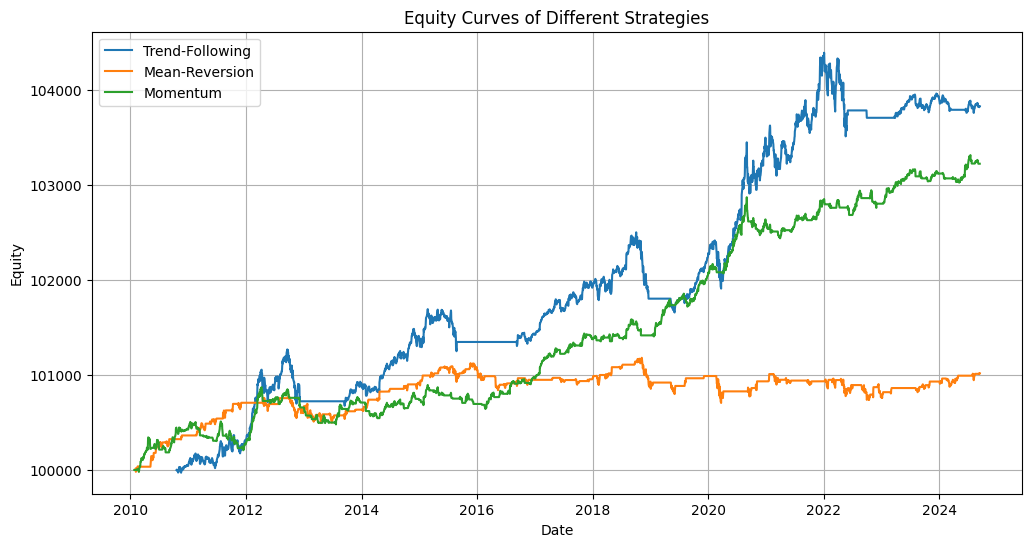

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your equity curves are stored as pandas Series with the timestamp as the index.
# Remove duplicates by keeping the last occurrence in case of duplicates.
trend_following_equity_curve = trend_following_equity_curve[~trend_following_equity_curve.index.duplicated(keep='last')]
mean_reversion_equity_curve = mean_reversion_equity_curve[~mean_reversion_equity_curve.index.duplicated(keep='last')]
momentum_equity_curve = momentum_equity_curve[~momentum_equity_curve.index.duplicated(keep='last')]

# Function to calculate CAGR (Compound Annual Growth Rate)
def calculate_cagr(equity_curve):
    n_years = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
    cagr = (equity_curve[-1] / equity_curve[0]) ** (1 / n_years) - 1
    return cagr

# Function to calculate Sharpe Ratio (using a risk-free rate of 0 for simplicity)
def calculate_sharpe_ratio(equity_curve):
    returns = equity_curve.pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    return sharpe_ratio

# Function to calculate Maximum Drawdown
def calculate_max_drawdown(equity_curve):
    cumulative_max = equity_curve.cummax()
    drawdown = equity_curve / cumulative_max - 1
    max_drawdown = drawdown.min()
    return max_drawdown

# Calculate performance metrics for each strategy
strategies = {
    "Trend-Following": trend_following_equity_curve,
    "Mean-Reversion": mean_reversion_equity_curve,
    "Momentum": momentum_equity_curve
}

performance_metrics = {}

for strategy_name, equity_curve in strategies.items():
    cagr = calculate_cagr(equity_curve)
    sharpe_ratio = calculate_sharpe_ratio(equity_curve)
    max_drawdown = calculate_max_drawdown(equity_curve)
    performance_metrics[strategy_name] = {
        "CAGR": cagr,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

# Print performance metrics
for strategy, metrics in performance_metrics.items():
    print(f"Performance Metrics for {strategy}:")
    print(f"CAGR: {metrics['CAGR']:.2%}")
    print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    print(f"Max Drawdown: {metrics['Max Drawdown']:.2%}\n")

# Plot equity curves
plt.figure(figsize=(12, 6))
for strategy_name, equity_curve in strategies.items():
    plt.plot(equity_curve.index, equity_curve, label=strategy_name)

plt.title("Equity Curves of Different Strategies")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_30/3354752367.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = (equity_curve[-1] / equity_curve[0]) ** (1 / n_years) - 1
/tmp/ipykernel_30/3354752367.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = equity_curve[-1] / equity_curve[0] - 1
/tmp/ipykernel_30/3354752367.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = equity_curve[-1] / equity_curve[0] - 1


Performance Metrics for Trend-Following:
CAGR: 0.27%
Sharpe Ratio: 0.63
Sortino Ratio: 0.71
Max Drawdown: -0.84%
Cumulative Return: 3.83%
Annualized Return: 0.27%

Performance Metrics for Mean-Reversion:
CAGR: 0.07%
Sharpe Ratio: 0.37
Sortino Ratio: 0.31
Max Drawdown: -0.47%
Cumulative Return: 1.02%
Annualized Return: 0.07%

Performance Metrics for Momentum:
CAGR: 0.22%
Sharpe Ratio: 1.08
Sortino Ratio: 1.19
Max Drawdown: -0.42%
Cumulative Return: 3.22%
Annualized Return: 0.22%



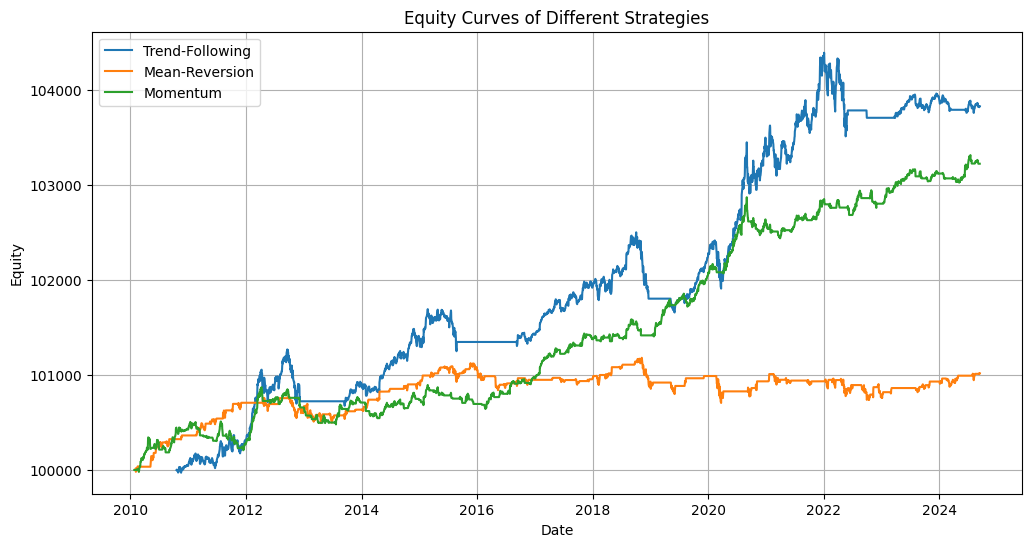

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your equity curves are stored as pandas Series with the timestamp as the index.
# Remove duplicates by keeping the last occurrence in case of duplicates.
trend_following_equity_curve = trend_following_equity_curve[~trend_following_equity_curve.index.duplicated(keep='last')]
mean_reversion_equity_curve = mean_reversion_equity_curve[~mean_reversion_equity_curve.index.duplicated(keep='last')]
momentum_equity_curve = momentum_equity_curve[~momentum_equity_curve.index.duplicated(keep='last')]

# Function to calculate CAGR (Compound Annual Growth Rate)
def calculate_cagr(equity_curve):
    n_years = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
    cagr = (equity_curve[-1] / equity_curve[0]) ** (1 / n_years) - 1
    return cagr

# Function to calculate Sharpe Ratio (using a risk-free rate of 0 for simplicity)
def calculate_sharpe_ratio(equity_curve):
    returns = equity_curve.pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    return sharpe_ratio

# Function to calculate Sortino Ratio (assuming a risk-free rate of 0 and only downside risk is penalized)
def calculate_sortino_ratio(equity_curve):
    returns = equity_curve.pct_change().dropna()
    downside_returns = returns[returns < 0]
    sortino_ratio = np.sqrt(252) * returns.mean() / downside_returns.std()
    return sortino_ratio

# Function to calculate Maximum Drawdown
def calculate_max_drawdown(equity_curve):
    cumulative_max = equity_curve.cummax()
    drawdown = equity_curve / cumulative_max - 1
    max_drawdown = drawdown.min()
    return max_drawdown

# Function to calculate Cumulative Return
def calculate_cumulative_return(equity_curve):
    cumulative_return = equity_curve[-1] / equity_curve[0] - 1
    return cumulative_return

# Function to calculate Annualized Return
def calculate_annualized_return(equity_curve):
    total_return = equity_curve[-1] / equity_curve[0] - 1
    n_years = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
    annualized_return = (1 + total_return) ** (1 / n_years) - 1
    return annualized_return

# Calculate performance metrics for each strategy
strategies = {
    "Trend-Following": trend_following_equity_curve,
    "Mean-Reversion": mean_reversion_equity_curve,
    "Momentum": momentum_equity_curve
}

performance_metrics = {}

for strategy_name, equity_curve in strategies.items():
    cagr = calculate_cagr(equity_curve)
    sharpe_ratio = calculate_sharpe_ratio(equity_curve)
    sortino_ratio = calculate_sortino_ratio(equity_curve)
    max_drawdown = calculate_max_drawdown(equity_curve)
    cumulative_return = calculate_cumulative_return(equity_curve)
    annualized_return = calculate_annualized_return(equity_curve)
    
    performance_metrics[strategy_name] = {
        "CAGR": cagr,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return
    }

# Print performance metrics
for strategy, metrics in performance_metrics.items():
    print(f"Performance Metrics for {strategy}:")
    print(f"CAGR: {metrics['CAGR']:.2%}")
    print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    print(f"Sortino Ratio: {metrics['Sortino Ratio']:.2f}")
    print(f"Max Drawdown: {metrics['Max Drawdown']:.2%}")
    print(f"Cumulative Return: {metrics['Cumulative Return']:.2%}")
    print(f"Annualized Return: {metrics['Annualized Return']:.2%}\n")

# Plot equity curves
plt.figure(figsize=(12, 6))
for strategy_name, equity_curve in strategies.items():
    plt.plot(equity_curve.index, equity_curve, label=strategy_name)

plt.title("Equity Curves of Different Strategies")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.grid(True)
plt.show()
